Load Sudoku Database

In [1]:
import numpy as np

quizzes = np.zeros((1000000, 81), np.int32)
solutions = np.zeros((1000000, 81), np.int32)
for i, line in enumerate(open('sudoku.csv', 'r').read().splitlines()[1:]):
    quiz, solution = line.split(",")
    for j, q_s in enumerate(zip(quiz, solution)):
        q, s = q_s
        quizzes[i, j] = q
        solutions[i, j] = s
quizzes = quizzes.reshape((-1, 9, 9))
solutions = solutions.reshape((-1, 9, 9))

Initial Parameters

In [2]:
refractory_period = 1.0
excitatory_tau = 5.0
inhibitory_tau = 6.0
inhibitory_weight = 5.0

excitatory_rate = 500.0
input_rate = 2000.0
excitatory_weight = 5.0

simulation_duration = 5000
scaleFactor = 5

gridSize = 9
gridRange = np.arange(gridSize)
sudokuSpikeData = np.zeros([gridSize**3])
sudokuSpikeTest = np.zeros([gridSize,gridSize])
liveViolations = []

Map Sudoku grid to 1D array values which represent neurons.

In [3]:
neuronMap = np.arange(gridSize**3).reshape(gridSize, gridSize, gridSize)
def neuron_index(column: int, row: int, layer: int) -> int:
    return neuronMap[layer, row, column]

Map Sudoku Grid by blocks to 1D array values which represent neurons

In [4]:
blockGrid = int(np.sqrt(gridSize))
blockMap = np.arange(gridSize).reshape(blockGrid,blockGrid)
def neuron_index_block(cell: int, block: int, layer: int) -> int:
    targetLayer = neuronMap[layer,:,:]
    blockcoords = np.where(blockMap==block)
    
    blockSplit1 = np.split(targetLayer,blockGrid,axis=0)[int(blockcoords[0])]
    
    blockSplit2 = np.split(blockSplit1,blockGrid,axis=1)[int(blockcoords[1])]

    return blockSplit2.flatten()[cell]

Grid Validation and printing

In [5]:
def grid_to_string(grid: np.ndarray):
    top = "┌───┬───┬───┬───┬───┬───┬───┬───┬───┐\n"
    value = "│ {} │ {} │ {} │ {} │ {} │ {} │ {} │ {} │ {} │\n"
    divider = "├───┼───┼───┼───┼───┼───┼───┼───┼───┤\n"
    bottom = "└───┴───┴───┴───┴───┴───┴───┴───┴───┘"
    printGrid = top + (value + divider)*8 + value + bottom
    return printGrid.format(
        *[" " if value == 0 else str(int(value)) for value in grid.flatten()]
    )

def grid_constraint_violations(grid: np.ndarray):
    expected = {1, 2, 3, 4, 5, 6, 7, 8, 9}
    result = 0
    for column in gridRange:
        if set(grid[:, column]) != expected:
            result += 1
    for row in gridRange:
        if set(grid[row, :]) != expected:
            result += 1
    for block in gridRange:
        blockcoords = np.where(blockMap==block)
        blockSplit1 = np.split(grid,blockGrid,axis=0)[int(blockcoords[0])]
        blockSplit2 = np.split(blockSplit1,blockGrid,axis=1)[int(blockcoords[1])]
        if set(blockSplit2.flatten()) != expected:
            result += 1
    return result

Choose a random sudoku

In [6]:
selection = np.random.randint(0,999999)
quiz = quizzes[selection,:,:]
solution = solutions[selection,:,:]

print(grid_to_string(solution), grid_constraint_violations(solution))

print(grid_to_string(quiz), grid_constraint_violations(quiz))

┌───┬───┬───┬───┬───┬───┬───┬───┬───┐
│ 8 │ 5 │ 4 │ 3 │ 1 │ 7 │ 2 │ 6 │ 9 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 3 │ 6 │ 7 │ 2 │ 9 │ 8 │ 4 │ 5 │ 1 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 1 │ 9 │ 2 │ 4 │ 6 │ 5 │ 8 │ 7 │ 3 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 4 │ 7 │ 9 │ 6 │ 5 │ 3 │ 1 │ 2 │ 8 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 5 │ 2 │ 1 │ 8 │ 4 │ 9 │ 7 │ 3 │ 6 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 6 │ 8 │ 3 │ 1 │ 7 │ 2 │ 9 │ 4 │ 5 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 7 │ 3 │ 5 │ 9 │ 2 │ 1 │ 6 │ 8 │ 4 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 9 │ 4 │ 8 │ 7 │ 3 │ 6 │ 5 │ 1 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 1 │ 6 │ 5 │ 8 │ 4 │ 3 │ 9 │ 7 │
└───┴───┴───┴───┴───┴───┴───┴───┴───┘ 0
┌───┬───┬───┬───┬───┬───┬───┬───┬───┐
│   │   │   │   │ 1 │   │   │ 6 │ 9 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 3 │   │ 7 │ 2 │   │   │   │ 5 │   │
├───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 1 │   │ 2 │ 4 │ 6 │ 5 │   │ 7 │   │
├───┼───┼───┼───┼───┼───┼───┼───┼───┤
│   │ 7 │ 

Generate input population and connection list

In [7]:
inputSize = np.count_nonzero(quiz)
inputNeurons = np.arange(inputSize)

inputConnections = []
ind = 0
for row in gridRange:
    for column in gridRange:
        if quiz[row,column] != 0:
            inputConnections.append(
                        (
                        inputNeurons[ind],
                        neuron_index(row, column, quiz[row,column]-1)
                        )
                    )
            ind += 1

In [8]:
assert inputSize == len(inputConnections)

Create a list of inhibitory connections that will be used by the network

In [9]:
gridRange = np.arange(gridSize)
connections = []
#
for layer in gridRange:
    for row in gridRange:
        for column1 in gridRange:
            for column2 in gridRange:
                if column1 != column2:
                    connections.append(
                        (
                        neuron_index(column1, row, layer),
                        neuron_index(column2, row, layer)
                        )
                    )
                    
for layer in gridRange:
    for column in gridRange:
        for row1 in gridRange:
            for row2 in gridRange:
                if row1 != row2:
                    connections.append(
                        (
                        neuron_index(column, row1, layer),
                        neuron_index(column, row2, layer)
                        )
                    )
                    
                 
for row in gridRange:
    for column in gridRange:
        for layer1 in gridRange:
            for layer2 in gridRange:
                if layer1 != layer2:
                    connections.append(
                        (
                        neuron_index(column, row, layer1),
                        neuron_index(column, row, layer2)
                        )
                    )   

for layer in gridRange:
    for block in gridRange:
        for cell1 in gridRange:
            cell1x = int(np.where(blockMap==cell1)[0])
            cell1y = int(np.where(blockMap==cell1)[1])
            for cell2 in gridRange:
                cell2x = int(np.where(blockMap==cell2)[0])
                cell2y = int(np.where(blockMap==cell2)[1])
                if cell1x != cell2x and cell1y != cell2y:
                    connections.append(
                        (
                        neuron_index_block(cell1, block, layer),
                        neuron_index_block(cell2, block, layer)
                        )
                    )            

Check list contains no duplicates

In [10]:
assert len(connections) == len(set(connections))

Start neural network simulation initialisation.

In [11]:
import pyNN.spiNNaker as sim

sim.setup(timestep = 1.0, time_scale_factor=scaleFactor)
sim.set_number_of_neurons_per_core(sim.IF_curr_exp, 100)

2022-11-06 02:22:20 INFO: Read cfg files: c:\Users\damie\miniconda3\envs\spinnaker\lib\site-packages\spinn_front_end_common\interface\spinnaker.cfg, c:\Users\damie\miniconda3\envs\spinnaker\lib\site-packages\spynnaker\pyNN\spynnaker.cfg, C:\Users\damie\.spynnaker.cfg
2022-11-06 02:22:20 INFO: Will search these locations for binaries: c:\Users\damie\miniconda3\envs\spinnaker\lib\site-packages\spinn_front_end_common\common_model_binaries : c:\Users\damie\miniconda3\envs\spinnaker\lib\site-packages\spynnaker\pyNN\model_binaries
2022-11-06 02:22:20 INFO: Setting time scale factor to 5.
2022-11-06 02:22:20 INFO: Setting machine time step to 1000 micro-seconds.


['c:\\Users\\damie\\miniconda3\\envs\\spinnaker\\lib\\site-packages\\spinn_front_end_common\\interface\\spinnaker.cfg', 'c:\\Users\\damie\\miniconda3\\envs\\spinnaker\\lib\\site-packages\\spynnaker\\pyNN\\spynnaker.cfg', 'C:\\Users\\damie\\.spynnaker.cfg']


Set up sudoku population which will represent the sudoku board.

In [12]:
sudokuPop = sim.Population(
    gridSize**3, 
    sim.IF_curr_exp(
        tau_syn_E = excitatory_tau,
        tau_syn_I = inhibitory_tau,
        tau_refrac = refractory_period
        ),
    label="sudPop"
)

sudokuPop.record(["spikes", "v"])

Set up inhibitory connections using list created earlier.

In [13]:
inhibitory_projection = sim.Projection(
    sudokuPop,
    sudokuPop,
    sim.FromListConnector([(source, target, inhibitory_weight) for source, target in connections], column_names=["weight"]),
    synapse_type=sim.StaticSynapse(),
    receptor_type="inhibitory",
)

Set up targeted inputs to favour existing values as an input.

In [14]:
inputPop = sim.Population(
    inputSize, 
    sim.SpikeSourcePoisson(rate = input_rate), 
    label="inputPop"
)

Setup excitatory connections between targeted input and sudoku population to feed targeted noise to drive a specific solution.

In [15]:
input_proj = sim.Projection(
    inputPop, 
    sudokuPop, 
    sim.FromListConnector([(source, target, excitatory_weight) for source, target in inputConnections], column_names=["weight"]),
    synapse_type=sim.StaticSynapse()
)

Set up a random spike input source to drive computation.

In [16]:
excitationPop = sim.Population(
    gridSize**3, 
    sim.SpikeSourcePoisson(rate = excitatory_rate), 
    label="excitationPop"
)

Setup excitatory connections between spike input and sudoku population to feed poisson noise to drive excitation.

In [17]:
excitation_proj = sim.Projection(
    excitationPop, 
    sudokuPop, 
    sim.OneToOneConnector(),
    synapse_type=sim.StaticSynapse(weight=excitatory_weight, delay=1)
)

Start simulation.

In [18]:
simtime = simulation_duration
sim.run(simtime)
neo = sudokuPop.get_data(variables=["spikes", "v"])
spikes = neo.segments[0].spiketrains
v = neo.segments[0].filter(name='v')[0]
sim.end()

2022-11-06 02:22:20 INFO: Starting execution process
2022-11-06 02:22:20 INFO: Simulating for 5000 1.0ms timesteps using a hardware timestep of 5000us
2022-11-06 02:22:20 INFO: Creating transceiver for 192.168.240.253
2022-11-06 02:22:20 INFO: Working out if machine is booted
2022-11-06 02:22:20 INFO: Found board with version [Version: SC&MP 3.4.1 at SpiNNaker:0:0:0 (built Fri Feb 12 01:36:44 2021)]
2022-11-06 02:22:20 INFO: Machine communication successful
2022-11-06 02:22:20 INFO: Detected a machine on IP address 192.168.240.253 which has 72 cores and 8.0 links
2022-11-06 02:22:20 INFO: Time 0:00:00.019728 taken by MachineGenerator
Preallocating resources for Extra Monitor support vertices
|0%                          50%                         100%|
2022-11-06 02:22:20 INFO: Time 0:00:00.005892 taken by PreAllocateResourcesForExtraMonitorSupport
2022-11-06 02:22:20 INFO: Time 0:00:00.000907 taken by NetworkSpecificationReport
Allocating virtual identifiers
|0%                      

Count number of spikes for a given neuron in a given time frame.

In [19]:
def count(column: int, row: int, layer: int, t0: int, t1: int):
    temp = spikes[int(neuronMap[layer,row,column])]
    temp = temp[temp>=t0]
    temp = temp[temp<t1]
    return np.shape(temp)[0]

Compare spike activity across layers and return layer with the most spike activity for a given time frame.

In [20]:
def most_active(column: int, row: int, t0: int, t1: int):
    layers = np.arange(np.shape(neuronMap)[0])
    maxLayer = np.argmax([count(column, row, layer, t0, t1) for layer in layers])
    return maxLayer

Get sudoku board and violations over the course of the simulation.

In [21]:
window = 50
violations = []
timeFrame = np.arange(0,simulation_duration, window)
for t in timeFrame:
    sudokuData = np.zeros([gridSize,gridSize])
    #sudokuActivity = np.zeros([gridSize,gridSize])
    for row in np.arange(np.shape(neuronMap)[1]):
        for column in np.arange(np.shape(neuronMap)[2]):
            layer = most_active(column, row, 0, t)
            sudokuData[column, row] = layer+1
            #sudokuActivity[column, row] = count(column, row, layer, 0, t)
    violations.append(grid_constraint_violations(sudokuData))

#print(np.asarray(sudokuActivity,dtype=np.uint16))

Plot violations over time.

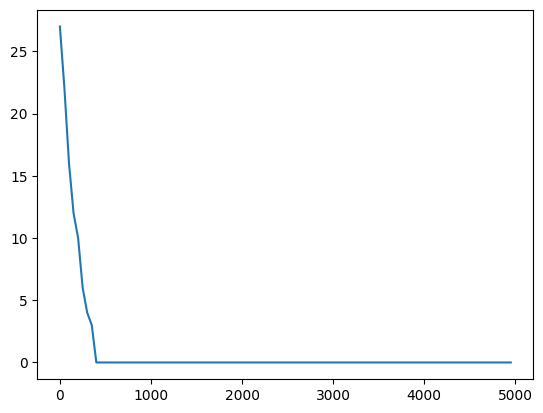

In [22]:
import matplotlib.pyplot as plt

plt.plot(timeFrame, violations)
plt.show()

Print the grid at the end of the simulation.

In [23]:
print(grid_to_string(sudokuData), grid_constraint_violations(sudokuData))

┌───┬───┬───┬───┬───┬───┬───┬───┬───┐
│ 8 │ 5 │ 4 │ 3 │ 1 │ 7 │ 2 │ 6 │ 9 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 3 │ 6 │ 7 │ 2 │ 9 │ 8 │ 4 │ 5 │ 1 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 1 │ 9 │ 2 │ 4 │ 6 │ 5 │ 8 │ 7 │ 3 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 4 │ 7 │ 9 │ 6 │ 5 │ 3 │ 1 │ 2 │ 8 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 5 │ 2 │ 1 │ 8 │ 4 │ 9 │ 7 │ 3 │ 6 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 6 │ 8 │ 3 │ 1 │ 7 │ 2 │ 9 │ 4 │ 5 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 7 │ 3 │ 5 │ 9 │ 2 │ 1 │ 6 │ 8 │ 4 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 9 │ 4 │ 8 │ 7 │ 3 │ 6 │ 5 │ 1 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 1 │ 6 │ 5 │ 8 │ 4 │ 3 │ 9 │ 7 │
└───┴───┴───┴───┴───┴───┴───┴───┴───┘ 0


In [24]:
print(grid_to_string(solution), grid_constraint_violations(solution))

┌───┬───┬───┬───┬───┬───┬───┬───┬───┐
│ 8 │ 5 │ 4 │ 3 │ 1 │ 7 │ 2 │ 6 │ 9 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 3 │ 6 │ 7 │ 2 │ 9 │ 8 │ 4 │ 5 │ 1 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 1 │ 9 │ 2 │ 4 │ 6 │ 5 │ 8 │ 7 │ 3 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 4 │ 7 │ 9 │ 6 │ 5 │ 3 │ 1 │ 2 │ 8 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 5 │ 2 │ 1 │ 8 │ 4 │ 9 │ 7 │ 3 │ 6 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 6 │ 8 │ 3 │ 1 │ 7 │ 2 │ 9 │ 4 │ 5 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 7 │ 3 │ 5 │ 9 │ 2 │ 1 │ 6 │ 8 │ 4 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 9 │ 4 │ 8 │ 7 │ 3 │ 6 │ 5 │ 1 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 1 │ 6 │ 5 │ 8 │ 4 │ 3 │ 9 │ 7 │
└───┴───┴───┴───┴───┴───┴───┴───┴───┘ 0


In [25]:
test = np.subtract(sudokuData,solution)
if test.all() == 0:
    print("Solved!")

Solved!
